# Problem 2

## Setup

In [1]:
import sys
import numpy as np

sys.path.append("../src")

from nat2324.problems.sumplete import Sumplete
from nat2324.algorithms.ga import BinaryGeneticAlgorithm
import matplotlib.pyplot as plt
from nat2324.utils import run_optimization_experiment, visualize_optimization_experiments

%load_ext autoreload
%autoreload 2

In [2]:
def experiment_callback(*args, **kwargs):
    # Pop the parameters that are specific to Sumplete GA
    k = kwargs.pop("K", 7)
    high = kwargs.pop("high", 9)
    evaluation_type = kwargs.pop("evaluation_type", "row_col")

    # Create the Sumplete problem and set D to be the square of K
    sumplete = Sumplete(K=k, evaluation_type=evaluation_type, low=1, high=high)
    kwargs["fitness_fn"] = sumplete
    kwargs['D'] = k ** 2
    
    return BinaryGeneticAlgorithm.experiment_callback(*args, **kwargs)

def lognorm(x: np.ndarray, y: np.ndarray):
    # Log rescaling and slope subtraction
    y_lin = np.log(y)
    slopes = (y_lin[-1, :] - y_lin[0, :]) / len(x)
    return y_lin - slopes[None, :] * np.arange(len(x))[:, None]

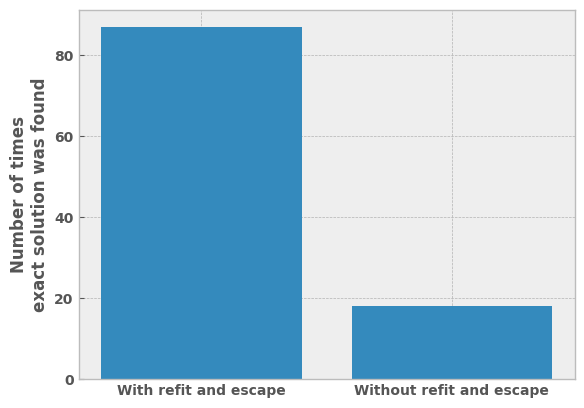

In [46]:
# Initialize the sumplete problem with K=7 and evaluation_type="sum"
sumplete = Sumplete(K=7, evaluation_type="sum", low=1, high=9)

# Setup variable params
experiment_setup = {
    ("use_refit", "use_escape"): [(True, True), (False, False)],
}

# Setup static params
default_kwargs = {
    "fitness_fn": sumplete,
    'D': sumplete.K**2,
    "p_m": 0.35,
    "mutation_type": "row_col_shuffle",
    "crossover_type": "n_point",
    "tournament_size": 4,
    "num_cross_points": 3,
    "max_generations": 1000,
    "best_score": 1,
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    BinaryGeneticAlgorithm.experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=100,
    average=False,
    dirname="../experiments/problem2/runs",
)

# Visualize the results on a bar plot
labels = ["With refit and escape", "Without refit and escape"]
plt.bar(labels, (results[("use_refit", "use_escape")] >= 1).sum(axis=(1, 2)))
plt.xticks(fontsize=10, fontweight="bold")
plt.yticks(fontsize=10, fontweight="bold")
plt.ylabel("Number of times\nexact solution was found", fontsize=12, fontweight="bold")
plt.style.use("bmh")
plt.savefig("../experiments/problem2/plots/refit_escape.png", dpi=300)
plt.show()

## Question (a)

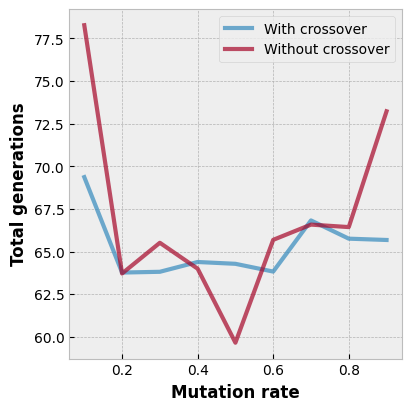

In [62]:
# Generate the sumplete game with absolute fitness evaluation
sumplete = Sumplete(K=4, evaluation_type="absolute", low=1, high=9)

# Setup variable params
experiment_setup  = {
    "p_flip": np.arange(0.1, 1.0, 0.1),
    "p_c": np.array([0.7, 0.0]),
}

# Setup static params
default_kwargs = {
    "fitness_fn": sumplete,
    'D': sumplete.K**2,
    "p_m": 1.0,
    "mutation_type": "bit_flip",
    "max_generations": 1000,
    "returnable": "num_generations",
    "best_score": 1,
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    BinaryGeneticAlgorithm.experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=1000,
    dirname="../experiments/problem2/runs",
)

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"Mutation rate": experiment_setup["p_flip"]},
    ys={"Total generations": results[("p_flip", "p_c")]},
    curve_labels=["With crossover", "Without crossover"],
    filepath="../experiments/problem2/plots/absolute_mutation.png",
)

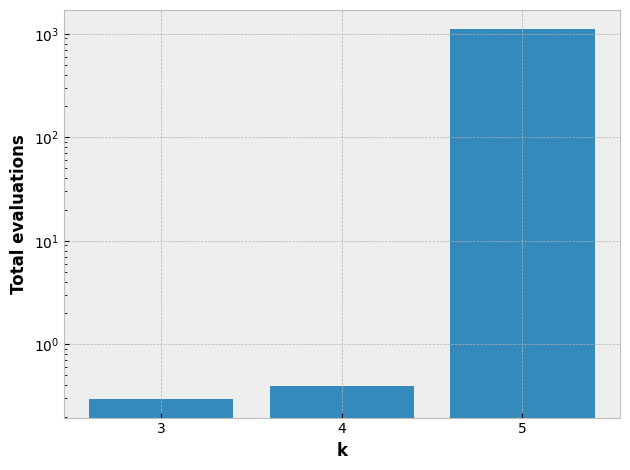

In [60]:
# Setup variable params
experiment_setup  = {
    ('N', 'K'): [(1, 3), (66, 4), (33554, 5)],
}

# Setup static params
default_kwargs = {
    "evaluation_type": "absolute",
    "use_refit": False,
    "use_escape": False,
    "p_m": 1.0,
    "p_flip": 0.5,
    "mutation_type": "bit_flip",
    "max_generations": 10000,
    "best_score": 1,
    "returnable": ("score", "duration", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=10,
    average=False,
    dirname="../experiments/problem2/runs",
)

# Check the average number of total evaluations
num_eval = results[('N', 'K')][:, 0, 1:2].mean(axis=1)
xticks = [nk[1] for nk in experiment_setup[("N", "K")]]

# Visualize the results on a bar plot
plt.bar(xticks, num_eval)
plt.xticks(xticks)
plt.yscale("log")
plt.xlabel("k", fontsize=12, fontweight="bold")
plt.ylabel("Total evaluations", fontsize=12, fontweight="bold")
plt.style.use("bmh")
plt.tight_layout()
plt.savefig("../experiments/problem2/plots/absolute_k.png", dpi=300)
plt.show()

## Question (b)

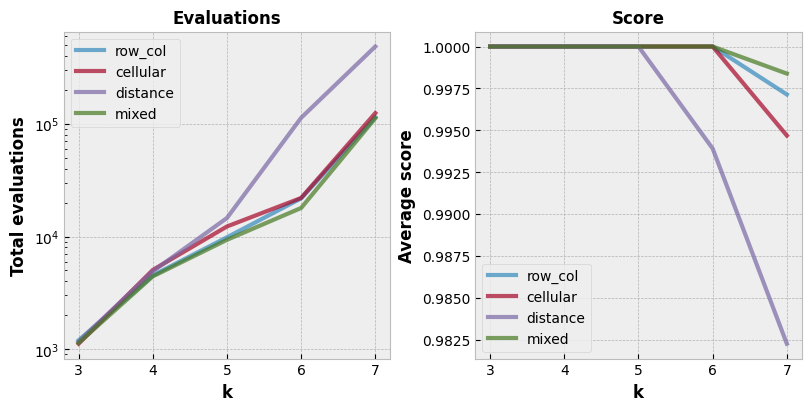

In [5]:
# Setup variable params
experiment_setup  = {
    'K': [3, 4, 5, 6, 7],
    "evaluation_type": ["row_col", "cellular", "distance", "mixed"],
}

# Setup static params
default_kwargs = {
    "crossover_type": "row_col_swap",
    "mutation_type": "row_col_shuffle",
    "max_generations": 2000,
    "best_score": 1,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=100,
    is_cartesian_product=True,
    dirname="../experiments/problem2/runs",
)

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": experiment_setup['K']},
    ys={"Evaluations": results[('K', "evaluation_type")][:, :, 1],
        "Score": results[('K', "evaluation_type")][:, :, 0]},
    curve_labels=experiment_setup["evaluation_type"],
    labels=["Total evaluations", "Average score"],
    scales=["log", "linear"],
    filepath="../experiments/problem2/plots/sumplete_k.png",
)

## Question (c)

### Selection

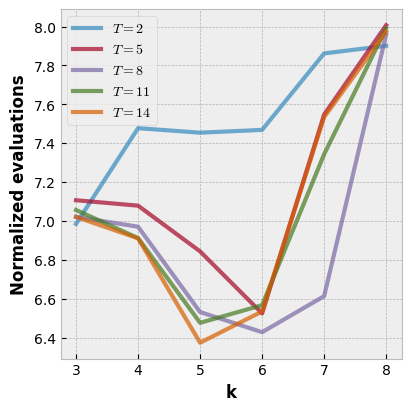

In [91]:
# Setup variable params
experiment_setup  = {
    'K': [3, 4, 5, 6, 7, 8],
    "tournament_size": np.arange(2, 15, 3),
}

# Setup static params
default_kwargs = {
    "crossover_type": "row_col_swap",
    "mutation_type": "bit_flip",
    "max_generations": 1000,
    "best_score": 1,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=50,
    is_cartesian_product=True,
    dirname="../experiments/problem2/runs",
)

# Normalize the results (compute the log and subtract the slope)
y_norm = lognorm(experiment_setup["K"], results[('K', "tournament_size")][:, :, 1])

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": experiment_setup['K']},
    ys={"Normalized evaluations": y_norm},
    curve_labels=[f"$T = {t}$" for t in experiment_setup["tournament_size"]],
    filepath="../experiments/problem2/plots/tournament_size.png",
)

### Crossover

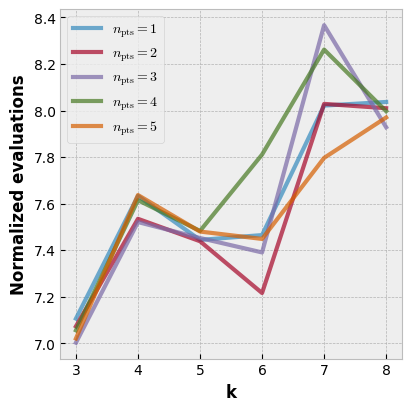

In [88]:
# Setup variable params
experiment_setup = {
    'K': [3, 4, 5, 6, 7, 8],
    "num_cross_points": np.arange(1, 6),
}

# Setup static params
default_kwargs = {
    "crossover_type": "n_point",
    "mutation_type": "bit_flip",
    "p_m": 0.05,
    "max_generations": 1000,
    "best_score": 1,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=50,
    is_cartesian_product=True,
    dirname="../experiments/problem2/runs",
)

# Normalize the results (compute the log and subtract the slope)
y_norm = lognorm(experiment_setup["K"], results[('K', "num_cross_points")][:, :, 1])

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": experiment_setup["K"]},
    ys={"Normalized evaluations": y_norm},
    curve_labels=[f"$n_{{\\text{{pts}}}} = {n}$" for n in experiment_setup["num_cross_points"]],
    ignore_suffix_y=True,
    filepath="../experiments/problem2/plots/num_cross_points.png",
)

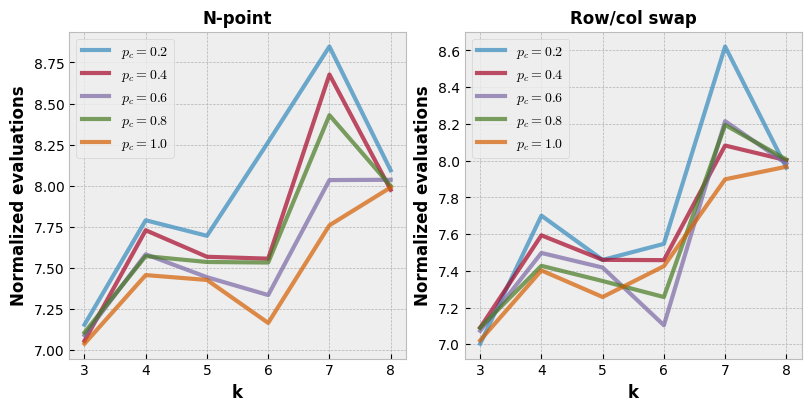

In [85]:
# Setup variable params
experiment_setup = {
    'K': [3, 4, 5, 6, 7, 8],
    "p_c": np.arange(0.2, 1.1, 0.2),
    "crossover_type": ["n_point", "row_col_swap"],
}

# Setup static params
default_kwargs = {
    "mutation_type": "bit_flip",
    "p_m": 0.05,
    "max_generations": 1000,
    "best_score": 1,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=50,
    is_cartesian_product=True,
    dirname="../experiments/problem2/runs",
)

# Normalize the results (compute the log and subtract the slope)
y_norm1 = lognorm(experiment_setup["K"], results[('K', "p_c", "crossover_type")][:, :, 0, 1])
y_norm2 = lognorm(experiment_setup["K"], results[('K', "p_c", "crossover_type")][:, :, 1, 1])

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": experiment_setup["K"]},
    ys={"N-point": y_norm1,
        "Row/col swap": y_norm2},
    curve_labels=[f"$p_c={p_c:.1f}$" for p_c in experiment_setup["p_c"]],
    labels="Normalized evaluations",
    ignore_suffix_y=True,
    filepath="../experiments/problem2/plots/crossover.png",
)

### Mutation

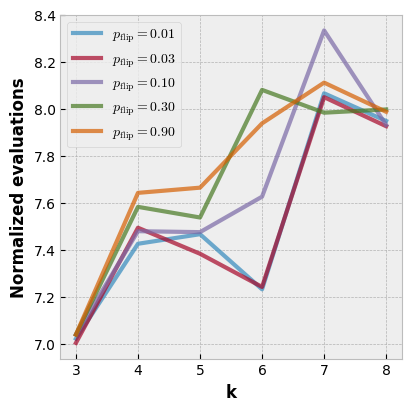

In [83]:
# Setup variable params
experiment_setup = {
    'K': [3, 4, 5, 6, 7, 8],
    "p_flip": [0.01, 0.03, 0.1, 0.3, 0.9],
}

# Setup static params
default_kwargs = {
    "crossover_type": "row_col_swap",
    "mutation_type": "bit_flip",
    "p_m": 0.2,
    "max_generations": 1000,
    "best_score": 1,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=50,
    is_cartesian_product=True,
    dirname="../experiments/problem2/runs",
)

# Normalize the results (compute the log and subtract the slope)
y_norm = lognorm(experiment_setup["K"], results[('K', "p_flip")][:, :, 1])

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": experiment_setup["K"]},
    ys={"Normalized evaluations": y_norm},
    curve_labels=[f"$p_\\text{{flip}}={p_flip:.2f}$" for p_flip in experiment_setup["p_flip"]],
    ignore_suffix_y=True,
    filepath="../experiments/problem2/plots/p_flip.png",
)

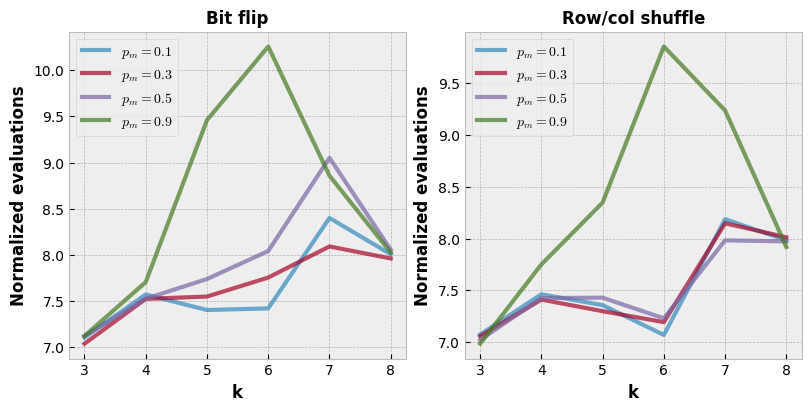

In [93]:
# Setup variable params
experiment_setup = {
    'K': [3, 4, 5, 6, 7, 8],
    "p_m": [0.1, 0.3, 0.5, 0.9],
    "mutation_type": ["bit_flip", "row_col_shuffle"],
}

# Setup static params
default_kwargs = {
    "crossover_type": "row_col_swap",
    "max_generations": 1000,
    "best_score": 1,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=50,
    is_cartesian_product=True,
    dirname="../experiments/problem2/runs",
)

# Normalize the results (compute the log and subtract the slope)
y_norm1 = lognorm(experiment_setup["K"], results[('K', "p_m", "mutation_type")][:, :, 0, 1])
y_norm2 = lognorm(experiment_setup["K"], results[('K', "p_m", "mutation_type")][:, :, 1, 1])

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": experiment_setup["K"]},
    ys={"Bit flip": y_norm1,
        "Row/col shuffle": y_norm2},
    curve_labels=[f"$p_m={p_c:.1f}$" for p_c in experiment_setup["p_m"]],
    labels="Normalized evaluations",
    ignore_suffix_y=True,
    filepath="../experiments/problem2/plots/mutation.png",
)

### Algorithmic

  0%|          | 0/24 [00:00<?, ?it/s]

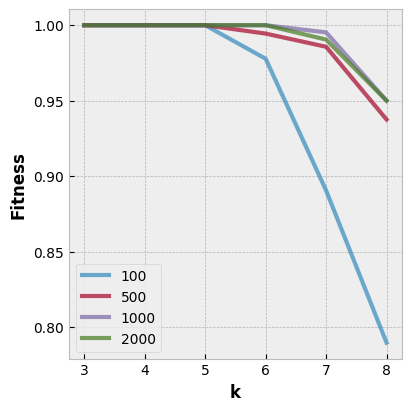

In [94]:
# Setup variable params
experiment_setup = {
    'K': [3, 4, 5, 6, 7, 8],
    "N": [100, 500, 1000, 2000],
}

# Setup static params
default_kwargs = {
    "crossover_type": "row_col_swap",
    "mutation_type": "bit_flip",
    "max_generations": 2000,
    "best_score": 1,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=30,
    is_cartesian_product=True,
    dirname="../experiments/problem2/runs",
)

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": experiment_setup['K']},
    ys={"Fitness": results[('K', 'N')][:, :, 0]},
    curve_labels=experiment_setup["N"],
    filepath="../experiments/problem2/plots/n.png",
)

  0%|          | 0/24 [00:00<?, ?it/s]

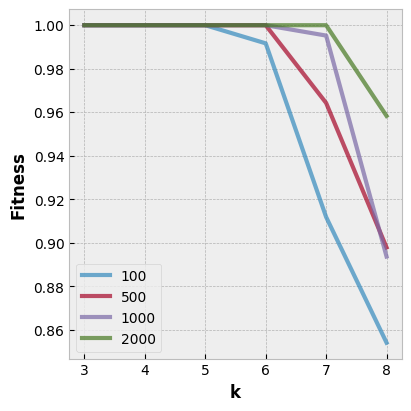

In [95]:
# Setup variable params
experiment_setup = {
    'K': [3, 4, 5, 6, 7, 8],
    "max_generations": [100, 500, 1000, 2000],
}

# Setup static params
default_kwargs = {
    "evaluation_type": "row_col",
    "crossover_type": "row_col_swap",
    "mutation_type": "bit_flip",
    "best_score": 1,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=30,
    is_cartesian_product=True,
    dirname="../experiments/problem2/runs",
)

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": experiment_setup['K']},
    ys={"Fitness": results[('K', "max_generations")][:, :, 0]},
    curve_labels=experiment_setup["max_generations"],
    filepath="../experiments/problem2/plots/max_generations.png",
)

## Appendix B

In [4]:
# Setup variable params
experiment_setup = {
    ('K', "high"): [(7, 49), (8, 64), (9, 81), (10, 100)],
}

# Setup static params
default_kwargs = {
    "best_score": 1,
    "max_generations": 200,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results1 = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=30,
    dirname="../experiments/problem2/runs",
)

In [3]:
# Setup variable params
experiment_setup = {
    'K': [7, 8, 9, 10]
}

# Setup static params
default_kwargs = {
    "best_score": 1,
    "max_generations": 200,
    "returnable": ("score", "num_evaluations"),
    "patience": None,
}

# Run the experiment based on variable params
results2 = run_optimization_experiment(
    experiment_callback,
    experiment_setup,
    default_kwargs,
    num_runs=30,
    dirname="../experiments/problem2/runs",
)

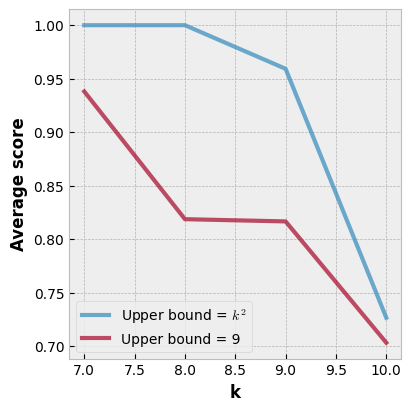

In [57]:
# Compute the combined fitness from both experiments
fitness = np.stack([results1[('K', 'high')][:, 0], results2['K'][:, 0]], axis=1)

# Visualize the results on a plot
visualize_optimization_experiments(
    xs={"k": [k for k in experiment_setup['K']]},
    ys={"Average score": fitness},
    curve_labels=["Upper bound = $k^2$", "Upper bound = 9"],
    filepath="../experiments/problem2/plots/game_complexity.png",
)